# Часть 1. Реализация [KNN](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D0%B1%D0%BB%D0%B8%D0%B6%D0%B0%D0%B9%D1%88%D0%B8%D1%85_%D1%81%D0%BE%D1%81%D0%B5%D0%B4%D0%B5%D0%B9) с помощью numpy

In [ ]:
# Напоминание про np.newaxis :)

## Метод К-ближайших соседей (K-neariest neighbor classifier)

Вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Перед выполнением задания:
- Положите в текущую директорию (/content/) файлы 'knn.py', 'metrics.py', 'dataset.py', `download_data.sh`. На колабе это можно сделать запуском ячейки с их загрузкой ниже

In [ ]:
!curl -L -o 'metrics.py' 'https://drive.google.com/uc?id=1vdWAatgE04qDSi9y-6dJhR293MQQMJkM&export=download&confirm=t'
!curl -L -o 'knn.py' 'https://drive.google.com/uc?id=1V1umd6JN6hxMNnKg9jIRJmp5RkkuEuX2&export=download&confirm=t'
!curl -L -o 'download_data.sh' 'https://drive.google.com/uc?id=1kKJFCKmrAQohhl8GtdJC2WFJvrVGBbq9&export=download&confirm=t'
!curl -L -o 'dataset.py' 'https://drive.google.com/uc?id=1Lt8bCBF4o-sFmz2Lqvw_4YTAqJIvQvv4&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   981  100   981    0     0    660      0  0:00:01  0:00:01 --:--:--  1657
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  4705  100  4705    0     0   2189      0  0:00:02  0:00:02 --:--:--  2189
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   136  100   136    0     0    102      0  0:00:01  0:00:01 --:--:--  132k
  % Total    % Received % Xferd  Average Speed   Tim

- запустите файл `download_data.sh`, чтобы скачать в директорию `data` данные, которые мы будем использовать для тренировки (data появится во время запуска bash-скрипта)

In [ ]:
! bash download_data.sh

--2023-11-10 19:43:26--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  8.36MB/s    in 25s     

2023-11-10 19:43:52 (6.88 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-11-10 19:43:52--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  11.9MB/s    in 5.5s    

2023-11-10 19:43:58 (11.1 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2023-11-10 19:43:58--
Total wall clock time: 31s
Downloaded: 2 files, 235M in

In [50]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy
import pandas as pd

## Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/).

In [52]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)

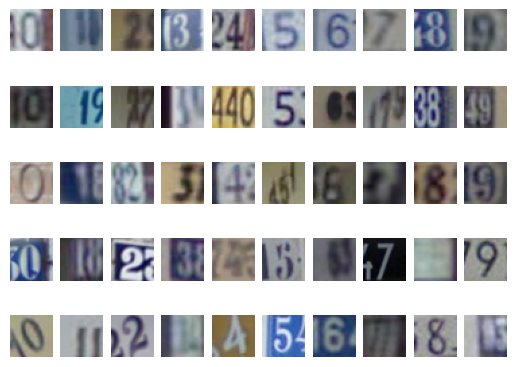

In [53]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [54]:
# Для начала подготовим метки и исходные  данные

# Выбираем только 0-ой и 9-ый классы
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Преобразуем в одномерный массив [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [55]:
# Создаем классификатор и вызываем .fit() для тренировки модели
# KNN просто запоминает все данные
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Пришло время написать код!

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

![](https://miro.medium.com/max/1400/0*cjh3izgm5Ldt62_S.png)

In [56]:
# TODO: реализуйте метод compute_distances_two_loops класса KNN в файле knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [57]:
# TODO: реализуйте метод compute_distances_one_loop класса KNN в файле knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [58]:
# TODO: реализуйте метод compute_distances_no_loops класса KNN в файле knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [59]:
# Посмотрим на разницу
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

12.4 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.6 ms ± 893 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
# TODO: реализуйте метод predict_labels_binary класса KNN в файле knn.py
prediction = knn_classifier.predict(binary_test_X)

In [61]:
# TODO: реализуйте функцию binary_classification_metrics в файле metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

KNN with k = 1
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


In [62]:
# Создадим экземпляр класса KNN с k=3 и посчитаем метрики
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

KNN with k = 3
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


## Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN!

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

In [63]:
# Подберем параметр k с помощью кросс-валидации на основе метрики F1
num_folds = 5
train_folds_X = np.array_split(binary_train_X, num_folds)
train_folds_y = np.array_split(binary_train_y, num_folds)

# TODO: Разделите данные на пять фолдов в train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # словарь привязки значений k к среднему F-меры (int -> float)


for k in k_choices:
    # TODO: реализуйте кросс-валидацию
    # Проитерируйтесь по фолдам, используя каждый для тестирования, а остальные для тренировки
    # Посчитайте F-меру
    # Устредните F1 по всем фолдам и запишите результат в словарь k_to_f1
    knn_classifier_k = KNN(k=k)
    f1_by_k = 0
    
    for num_f in range(num_folds):
        #текущий тестовый фолд
        f_test_X = train_folds_X[num_f]
        f_test_y = train_folds_y[num_f]
        
        #объединяем остальные фолды для тренировочного набора
        f_train_X = np.concatenate([train_folds_X[i] for i in range(num_folds) if i != num_f])
        f_train_y = np.concatenate([train_folds_y[i] for i in range(num_folds) if i != num_f])
        
        #обучаем модель на тренировочном наборе
        knn_classifier_k.fit(f_train_X, f_train_y)
        
        #предсказания на тестовом наборе
        prediction_k = knn_classifier_k.predict(f_test_X)
        
        #вычисляем метрику F1 для текущего фолда
        precision, recall, f1, accuracy = binary_classification_metrics(prediction_k, f_test_y)
        f1_by_k += f1
    
    #усредняем F1 по всем фолдам для текущего k
    k_to_f1[k] = f1_by_k / num_folds

for k in sorted(k_to_f1):
    print(f'k = {k}, f1 = {k_to_f1[k]:.6f}')


k = 1, f1 = 0.682784
k = 2, f1 = 0.523135
k = 3, f1 = 0.686164
k = 5, f1 = 0.607829
k = 8, f1 = 0.580787
k = 10, f1 = 0.590111
k = 15, f1 = 0.633256
k = 20, f1 = 0.646145
k = 25, f1 = 0.654244
k = 50, f1 = 0.590485


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [64]:
# TODO Установите значение best_k на лучшее значение кросс-валидации
best_k = max(k_to_f1, key=k_to_f1.get)

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1))

Best KNN with k = 3
Accuracy: 0.56, Precision: 0.73, Recall: 0.67, F1: 0.70


## Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [65]:
# Теперь воспользуемся всеми 10 классами
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [66]:
# TODO: Реализуйте метод predict_labels_multiclass класса KNN в файле knn.py
predict = knn_classifier.predict(test_X)

In [67]:
# TODO: Реализуйте функцию multiclass_accuracy в файле metrics.py
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [68]:
# Подберем параметр k с помощью кросс-валидации на основе метрики accuracy
num_folds = 5
train_folds_X = np.array_split(binary_train_X, num_folds)
train_folds_y = np.array_split(binary_train_y, num_folds)

# TODO: Разделите данные на пять фолдов в train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    accuracies = []
    # TODO: реализуйте кросс-валидацию
    # Проитерируйтесь по фолдам, используя каждый для тестирования, а остальные для тренировки
    # Посчитайте и устредните accuracy по всем фолдам, запишите результат в словарь k_to_accuracy
    for i in range(num_folds):
        #тестовый фолд
        X_test_fold = train_folds_X[i]
        y_test_fold = train_folds_y[i]
        #обучающая выборка из всех фолдов, кроме i-го
        X_train_fold = np.concatenate([train_folds_X[j] for j in range(num_folds) if j != i])
        y_train_fold = np.concatenate([train_folds_y[j] for j in range(num_folds) if j != i])
        
        #KNN с текущим значением k
        knn_classifier = KNN(k=k)
        knn_classifier.fit(X_train_fold, y_train_fold)
        
        #предсказания на тестовом фолде
        predictions = knn_classifier.predict(X_test_fold)
        
        #точность для текущего фолда
        accuracy = np.mean(predictions == y_test_fold)
        accuracies.append(accuracy)

    #усреднение точности по всем фолдам для текущего k
    k_to_accuracy[k] = np.mean(accuracies)

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

k = 1, accuracy = 0.635333
k = 2, accuracy = 0.561333
k = 3, accuracy = 0.618667
k = 5, accuracy = 0.512000
k = 8, accuracy = 0.494667
k = 10, accuracy = 0.495333
k = 15, accuracy = 0.511333
k = 20, accuracy = 0.527667
k = 25, accuracy = 0.519333
k = 50, accuracy = 0.486667


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [69]:
# TODO Установите значение best_k на лучшее значение кросс-валидации
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy должна быть около 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.21


# Часть 2. Sklearn

Проделайте шаги **многоклассовой** классификации с помощью библиотеки sklearn! Но чтобы не перебирать гиперпараметры вручную, рекомендую посмотреть документацию по такому объекту как GridSearchCV. Не ограничивайте себя в выборе моделей...

In [21]:
from sklearn.neighbors import KNeighborsClassifier

#knn классификатор
knn = KNeighborsClassifier()

In [22]:
from sklearn.model_selection import GridSearchCV

#параметры для поиска
param_grid = {'n_neighbors': [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]}

#экземпляр GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [23]:
#обучение при помощи GridSearchCV
grid_search.fit(train_X, train_y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'n_neighbors': 3}
Best cross-validation accuracy: 0.25999999999999995


In [24]:
from sklearn.metrics import accuracy_score

#предсказание на тестовом наборе
best_knn = grid_search.best_estimator_
test_predictions = best_knn.predict(test_X)

#метрика точности
test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Test accuracy: 0.25


## Анализ с матрицей ошибок

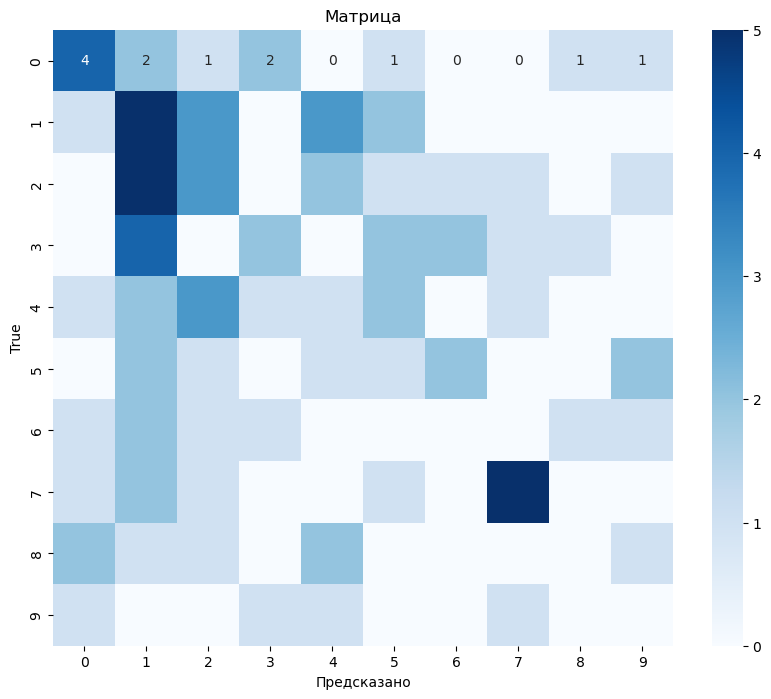

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_y, prediction)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Предсказано')
plt.ylabel('True')
plt.title('Матрица')
plt.show()

## Тестим StandardScaler

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#нормализация тестовых и тренировочных данных
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

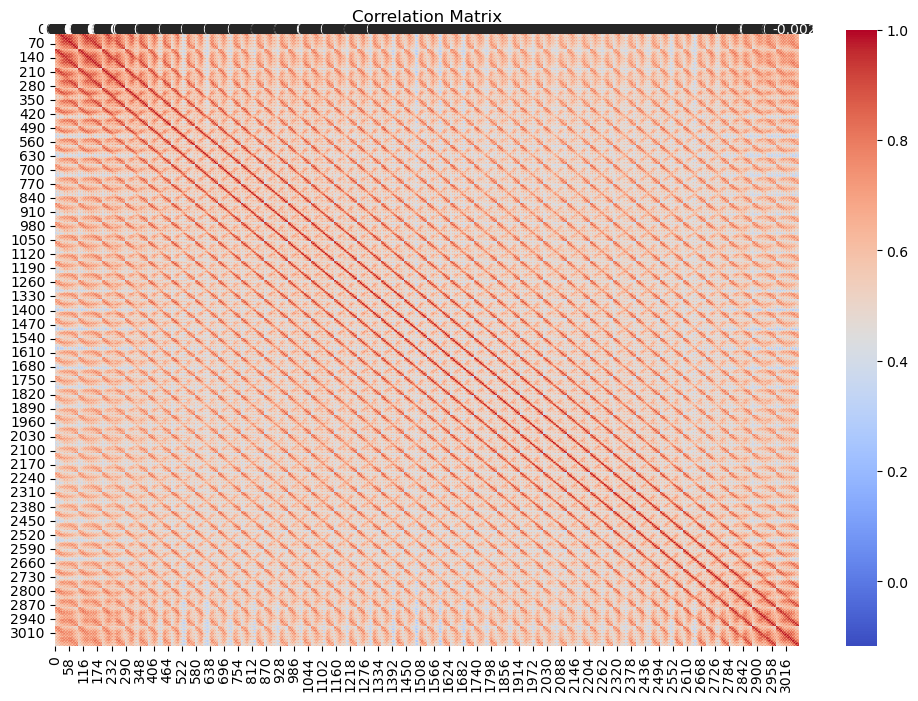

In [27]:
import pandas as pd

train_df = pd.DataFrame(train_X_normalized)
train_df['target'] = train_y

#корреляция между признаками и классами
correlation_matrix = train_df.corr()

#тепловая карта корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

много коррелирующих друг с другом элементов.
элем на диагон. - 1 (с самим собой?).
ближе к 0 - не зависят друг от друга

In [28]:
from sklearn.decomposition import PCA

#обучаем PCA
pca = PCA(n_components=20)  #сохраняем 20 наиболее важных компонент
train_X_pca = pca.fit_transform(train_X_normalized)
test_X_pca = pca.transform(test_X_normalized)

#дисперсия
print("Объясненный коэффициент дисперсии:", pca.explained_variance_ratio_)

Объясненный коэффициент дисперсии: [0.5744668  0.0595553  0.05252568 0.0386359  0.02889782 0.01718867
 0.01539725 0.01512909 0.01303553 0.01143225 0.01002067 0.00766032
 0.00673333 0.0059505  0.00551301 0.00490105 0.00481873 0.00469127
 0.00425859 0.00417538]


In [29]:
#сейвим 10 главных компонентов
pca = PCA(n_components=10)
train_X_pca = pca.fit_transform(train_X_normalized)
test_X_pca = pca.transform(test_X_normalized)

print("Объясненный коэффициент дисперсии:", sum(pca.explained_variance_ratio_))

Объясненный коэффициент дисперсии: 0.8262641951441765


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#KNN с PCA данными
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]}

#GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(train_X_pca, train_y)

#лучшие параметры и точность кросс-валидации
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

#оцениваем на тесте
best_knn = grid_search.best_estimator_
test_predictions = best_knn.predict(test_X_pca)

#точность
test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best parameters: {'n_neighbors': 8}
Best cross-validation accuracy: 0.217
Test accuracy: 0.20


___Лучший k = 8. Точность на кросс-валидации - 21.7%. На тесте - 20%.___

## Далее проба установить больше лучших параметров при помощи .best_params_, с PCA данными

In [31]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'cosine'],
    'p': [1, 2]  # p=1 Манхэттен, p=2 — Евклидово
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X_pca, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best crossvalidation accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
test_predictions = best_knn.predict(test_X_pca)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best параметры: {'metric': 'cosine', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Best crossvalidation accuracy: 0.251
Test accuracy: 0.20


## Логистическая регрессия

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  #регуляризационный параметр
    'penalty': ['l1', 'l2']  #L1 и L2
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X_pca, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best crossvalidation accuracy:", grid_search.best_score_)

best_log_reg = grid_search.best_estimator_
test_predictions = best_log_reg.predict(test_X_pca)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best параметры: {'C': 0.01, 'penalty': 'l1'}
Best crossvalidation accuracy: 0.193
Test accuracy: 0.14


___Вывод - логистическая регрессия не дообучена или банально не вывозит задачи такого типа___

## Наивный Байес

In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

#класс. Байес
gnb = GaussianNB()

#кросс валидация
cv_scores = cross_val_score(gnb, train_X_pca, train_y, cv=5, scoring='accuracy')

gnb.fit(train_X_pca, train_y)

test_predictions = gnb.predict(test_X_pca)

test_accuracy = accuracy_score(test_y, test_predictions)

print(f"Cross-validation accuracy: {cv_scores.mean():.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")

Cross-validation accuracy: 0.185
Test accuracy: 0.140


___Тот же вывод, что и с логистической регрессией___

## Древо Решений

In [34]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X_pca, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best crossvalidation accuracy:", grid_search.best_score_)

best_dtc = grid_search.best_estimator_
test_predictions = best_dtc.predict(test_X_pca)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best параметры: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best crossvalidation accuracy: 0.20600000000000002
Test accuracy: 0.20


## Результаты

1. Часть 1 с KNN: ___Accuracy: 0.21___
2. При настройках по умолчанию GridSearchCV, Test accuracy: 25% при лучших настройках в виде k = 3 и точности CR = 25%
3. При KNN с PCA и сохранением 10 компонентов, k = 8, точность CR = 21, Test accura = 20%
4. При смене гиперпараместров, CR = 25%, Test accuracy = 20%
5. При Логистической Регрессии, CR = 19%, Test = 14%
6. Наивный Байес выдал CR = 18.5%, Text = 14%
7. Древо Решений выдало CR = 20%, Test = 20%.

## Выводы

1. При настройках по умолчанию, GridSearchCV способен автоматически выбрать лучшие параметры для улучшения результата.
2. GridSearchCV позволяет не тратить время на написание класса своими ручками и суммарно уменьшает количество потраченного времени
3. PCA не помогает добиться лучшего результата в этой задаче, даже с GridSearchCV
4. Логистическая Регрессия плохо работает с задачей множественной классификации
5. С Байесом я вообще хз, как условная вероятность может работать в контексте этой задачи, но попробовать стоило
6. Древо Решений выдало +- адекватный результат в пределах требуемого

## Далее без PCA, но с большим количеством параметров

In [35]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
test_predictions = best_knn.predict(test_X)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best параметры: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation accuracy: 0.274
Test accuracy: 0.24


## Вывод:

___Без уменьшения компонентов при помощи PCA, KNN с GSCV результат в разы лучше при поиске подходящих параметров. Однако, если переборщить с количеством параметров при итерации, тестовая точность может уменьшиться___

## Далее также с Логистической регрессией и Древом Решений

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression(max_iter=1000, solver='liblinear')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']  #L1 и L2
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
best_log_reg = grid_search.best_estimator_
test_predictions = best_log_reg.predict(test_X)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Запомнить, что с Логистической регрессией долго отрабатывает и жоска лагает, ноут же готов отправиться в длительное путешествие к орбите из-за огромного количества параметров. Как оказалось, нагрузка на ЦП была 100%. Пришлось прервать и переписывать код.
Возможные проблемы:
1. Слишком много признаков и без PCA код банально будет слишком долго отрабатывает
2. Много параметров, из-за которых GSCV делает поиск по всем возможным комбинациям параметров, после чего делает для каждой комбы кросс-валидацию
3. Пришлось убрать другие параметры и оставить только C и penalty

___Тк код за час не отработал, пришлось прервать ячейку.___

In [36]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(train_X, train_y)

print("Best параметры:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_tree = grid_search.best_estimator_
test_predictions = best_tree.predict(test_X)

test_accuracy = accuracy_score(test_y, test_predictions)
print("Test accuracy: %4.2f" % test_accuracy)

Best параметры: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.22800000000000004
Test accuracy: 0.16


___Итого, на тестовых данных паршиво себя показало Дерево решений.___

___Вывод: лучше всего с большим количеством параметров отработал KNN, получив Test accuracy: 24%___

## Далее сберовский с 7 домашки

In [7]:
df_transactions=pd.read_csv('data2/transactions_train.csv')
df_target=pd.read_csv('data2/train_target.csv')

In [8]:
df_transactions.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


In [9]:
df_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


In [10]:
df_merge = pd.merge(df_transactions, df_target, on='client_id', how='inner')

In [11]:
df_merge.head(5)

,client_id,trans_date,small_group,amount_rur,bins
0,33172,6,4,71.463,0
1,33172,6,35,45.017,0
2,33172,8,11,13.887,0
3,33172,9,11,15.983,0
4,33172,10,11,21.341,0


In [12]:
df_small = pd.read_csv('data2/small_group_description.csv')

In [13]:
df_small.head(10)

,small_group,small_group_code
0,Зоотовары,0
1,Сетевые супермаркеты и продуктовые магазины,1
2,Обслуживание существующего автомобиля (АЗС),2
3,Оплата телефона и связи,3
4,Аптеки,4
5,Авиабилеты,5
6,Duty-free,6
7,Страховка,7
8,Спорт,8
9,Универсальные товары,9


___Не получилось использовать в качестве признаков small_group вместе с разбивкой trans_date на день\месяц\год, тк тупо оперативки не хватило___

___Пойдем через общую сумму транзакций и small_group___

In [14]:
#агрегация по клиентам
df_agg = df_merge.groupby('client_id').agg({
    'amount_rur': ['sum', 'count']
}).reset_index()

df_agg.columns = ['client_id', 'total_amount_rur', 'transaction_count']

In [15]:
df_agg.head()

,client_id,total_amount_rur,transaction_count
0,4,28404.121,720
1,6,15720.739,730
2,7,53630.036,773
3,10,34419.365,706
4,11,26789.404,812


In [16]:
df_pivot = df_merge.pivot_table(index='client_id', 
                                columns='small_group', 
                                values='amount_rur', 
                                aggfunc='sum', 
                                fill_value=0).reset_index()

In [17]:
df_pivot.head()

small_group,client_id,0,1,2,3,4,5,6,7,8,...,192,193,195,196,197,198,199,200,202,203
0,4,0.000,15049.897,98.966,835.403,3799.572,0.000,0.0,0.000,22.852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,53.372,9602.770,0.000,2905.083,189.480,0.000,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,89.072,4632.372,125.521,888.523,660.002,1241.557,0.0,118.975,197.820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,639.798,13440.506,24.928,2034.764,2422.679,0.000,0.0,0.000,270.330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,88.239,5037.288,0.000,637.526,178.423,1844.468,0.0,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_final = pd.merge(df_agg, df_pivot, on='client_id', how='left')

In [19]:
df_final.head()

,client_id,total_amount_rur,transaction_count,0,1,2,3,4,5,6,...,192,193,195,196,197,198,199,200,202,203
0,4,28404.121,720,0.000,15049.897,98.966,835.403,3799.572,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,15720.739,730,53.372,9602.770,0.000,2905.083,189.480,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,53630.036,773,89.072,4632.372,125.521,888.523,660.002,1241.557,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,34419.365,706,639.798,13440.506,24.928,2034.764,2422.679,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,26789.404,812,88.239,5037.288,0.000,637.526,178.423,1844.468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
target = df_merge.groupby('client_id').agg({'bins': 'first'}).reset_index()

In [51]:
df_final = pd.merge(df_final, target, on='client_id', how='left')

In [52]:
print(df_final.columns)

Index([        'client_id',  'total_amount_rur', 'transaction_count',
                         0,                   1,                   2,
                         3,                   4,                   5,
                         6,
       ...
                       193,                 195,                 196,
                       197,                 198,                 199,
                       200,                 202,                 203,
                    'bins'],
      dtype='object', length=206)


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = df_final.drop(columns=['client_id', 'bins'])
target = df_final['bins']

features.columns = features.columns.astype(str) #все имена к str иначе ошибка будет

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=42)

In [54]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [55]:
print(train_features_scaled.shape, test_features_scaled.shape)

(21000, 204) (9000, 204)


In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train_features_scaled, train_target)

test_predictions = knn.predict(test_features_scaled)

accuracy = accuracy_score(test_target, test_predictions)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.4557


## Теперь с GridSearchCV

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 21)  #тестим от 1 до 20
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')

grid_search.fit(train_features_scaled, train_target)

print(f'Best параметры: {grid_search.best_params_}')
print(f'Cross-validation accuracy: {grid_search.best_score_:.4f}')

best_knn = grid_search.best_estimator_
test_predictions = best_knn.predict(test_features_scaled)

accuracy = accuracy_score(test_target, test_predictions)
print(f'Test accuracy: {accuracy:.4f}')

Best параметры: {'n_neighbors': 19}
Cross-validation accuracy: 0.4711
Test accuracy: 0.4839


## Попробуем с Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(train_features_scaled, train_target)

print(f'Best параметры: {grid_search_rf.best_params_}')
print(f'Cross-validation accuracy: {grid_search_rf.best_score_:.4f}')

best_rf = grid_search_rf.best_estimator_
test_predictions_rf = best_rf.predict(test_features_scaled)

accuracy_rf = accuracy_score(test_target, test_predictions_rf)
print(f'Test accuracy: {accuracy_rf:.4f}')

Best параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Cross-validation accuracy: 0.5945
Test accuracy: 0.6019


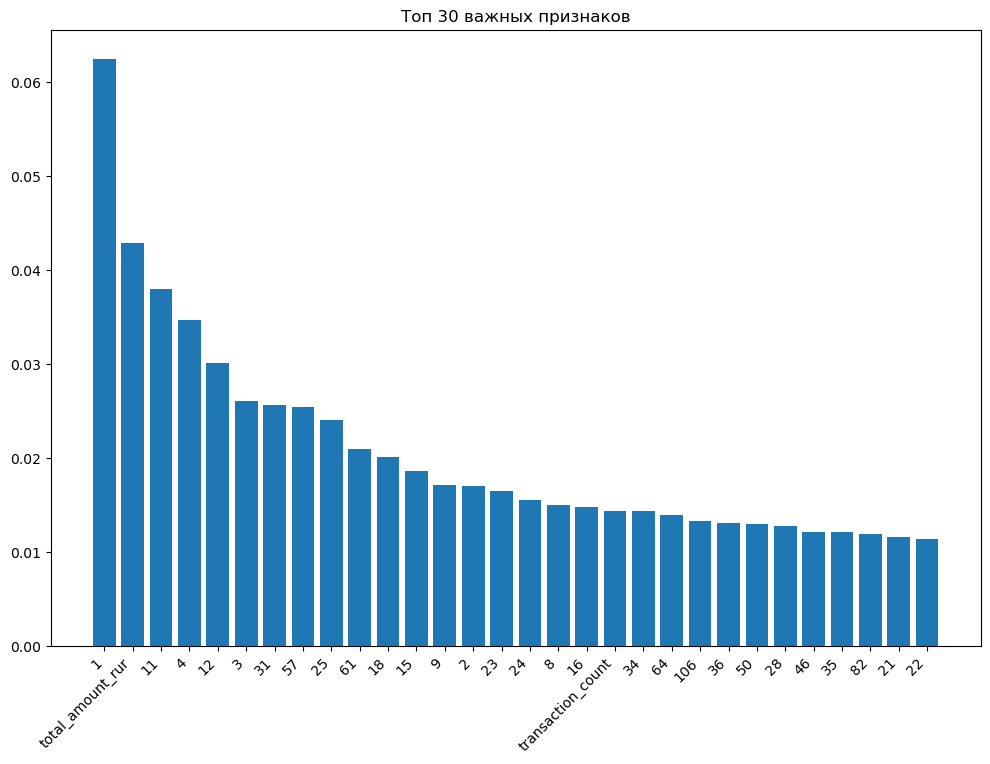

In [59]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

top_n = 30
top_indices = indices[:top_n]

plt.figure(figsize=(12, 8))
plt.title("Топ 30 важных признаков")
plt.bar(range(top_n), feature_importances[top_indices], align="center")
plt.xticks(range(top_n), train_features.columns[top_indices], rotation=45, ha='right', fontsize=10)
plt.show()

___Выводы с графика:___
1. total_amount_rur - самый важный признак
2. small_group - сильно решает, тк конкретные возрастные группы оплачивают конкретные типы услуг
3. transaction_count - количество трат также сильно влияет на результат

## Итого по сберу

1. С KNN без GridSearchCV - Test accuracy: 0.4557
2. С GridSearchCV чуть лучше - Test accuracy: 0.4839 при CR = 47% и K = 19
3. При RandomForest с GridSearchCV, код отработал за 15 минут с дикой нагрузкой.
4. При RandomForest - Test accuracy: 0.6019 ___лучший результат___